# Machine Learning Nanodegree - Capstone project

# Flower classification implementation

Import necessary Python packages (for loading, plotting, and augmenting data, building Neural Network, etc...)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
import json

from keras import backend as k
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from scipy.io import loadmat
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Using TensorFlow backend.


Splitting into three folders: Train, validation, Test. And setup hyper-parameters for tuning later.

In [2]:
test_labels_dir = '../files/imagelabels.mat'
benchmark_model_dir = '../models/benchmark_model.h5'
best_model_dir = '../models/best_model.h5'
final_model_dir = '../models/final_model.h5'
data_dir = '../flower_data'

cat_to_name_dir = 'cat_to_name.json'
TRAIN, VAL = 'train', 'valid'

train_in_file = os.path.join(data_dir, TRAIN)
valid_in_file = os.path.join(data_dir, VAL)

categories_in_file = os.path.join(data_dir, cat_to_name_dir)

# Hyper-parameters
input_size = (224, 224) # This size is dertermined by the size from VGG-19
channels = 3 # RGB
transform_ratio = 0.3 # For Data augmentation aggressiveness 
batch_size = 64
rescale_ratio = 1.0 / 255.0 # (RGB)
num_unfrozen_layers = 6 # for freezing custom layers later during Transfer Learning (we will create 6 custom layers)

In [3]:
# Save checkpoint in a target directory with accuracy
def get_checkpoint(target_directory):
     return ModelCheckpoint(
        target_directory,
        monitor='val_acc',
        save_best_only=True,
        verbose=1
    )

early_stopping = EarlyStopping(
    monitor='val_acc',
    mode='auto',
    min_delta=0.0, # Tuning this parameter for smallest amount to be `improvement`
    patience=5, # number of epochs with no improvement after which we stop
    verbose=1
)

# Data augmentation

Create Image generators for our flower data structure to have more options for our training model, by applying different transformations to our data images.

In [4]:
## Augmentation configuration is applied to Image Data Generator for training

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rescale=rescale_ratio,
    rotation_range=25,
    zoom_range=transform_ratio,
    shear_range=transform_ratio,
    cval=transform_ratio,
    fill_mode='nearest',
    validation_split=0.1 # Split training data into 90-10% fraction for validation data
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rescale=rescale_ratio,
    rotation_range=25,
    zoom_range=transform_ratio,
    shear_range=transform_ratio,
    cval=transform_ratio,
    fill_mode='nearest'
)

In [5]:
## Create Data generators for each folders, loading from given corresponding directories
## Note: both training and valid generator will be split up from training directory for 
## validation purposes.

train_generator = train_datagen.flow_from_directory(
    directory=train_in_file, # from `train` folder (load 90% data)
    target_size=input_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical", # Since we have more then 2 classes to predict
    shuffle=True,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    directory=train_in_file, # from `train` folder (load 10% data)
    target_size=input_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    directory=valid_in_file, # from `valid` folder for testing model after training
    target_size=input_size,
    batch_size=1,
    shuffle=False
)

Found 5943 images belonging to 102 classes.
Found 609 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


In [6]:
## Step sizes to fit and train our model later
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size

## Mapping Test label into JSON file
Displaying the test flower names from source as ground truth labels. We will compare these labels with our predictions produced by our trained model.

In [7]:
test_labels = loadmat(test_labels_dir)['labels'][0][:1000]
print(Counter(test_labels))

Counter({77: 251, 73: 194, 89: 183, 81: 166, 88: 152, 46: 54})


In [8]:
with open(categories_in_file) as json_file:
    flower_names = json.load(json_file)
    
## This will be used to test un-seen data
test_flower_names = [flower_names[str(label)] for label in test_labels[:len(test_generator.filenames)]]

print(Counter([(flower_names[str(label)], label) for label in test_labels]))
print(Counter([(flower_names[str(label)], label) for label in test_labels][:len(test_generator.filenames)]))

Counter({('passion flower', 77): 251, ('water lily', 73): 194, ('watercress', 89): 183, ('frangipani', 81): 166, ('cyclamen', 88): 152, ('wallflower', 46): 54})
Counter({('passion flower', 77): 251, ('water lily', 73): 194, ('watercress', 89): 183, ('cyclamen', 88): 152, ('frangipani', 81): 38})


# Data visualization

In [9]:
flower_images = []
start_index, num_samples = 2, 5

for index in range(start_index, start_index+num_samples):
    flower_images.append(glob.glob(train_in_file + '/{}/*'.format(index))[:num_samples])
    
flower_images = np.hstack(flower_images)

In [10]:
def display_image(img_paths, image_label=None, predicted_label=None):
    fig = plt.figure(figsize=(25, 20))
    indices = np.hstack([[i]*num_samples for i in range(start_index, start_index+num_samples+1)])
    
    for index in range(len(img_paths)):
        ax = fig.add_subplot(num_samples, len(img_paths)//num_samples, index+1, xticks=[], yticks=[])
        img = cv2.imread(img_paths[index])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(cv_rgb) # and convert from Tensor image

        flower_name = flower_names["{}".format(indices[index])]
        ax.set_title(flower_name)
        
        if predicted_label:
            ax.set_xlabel("This is {}".format(predicted_label))

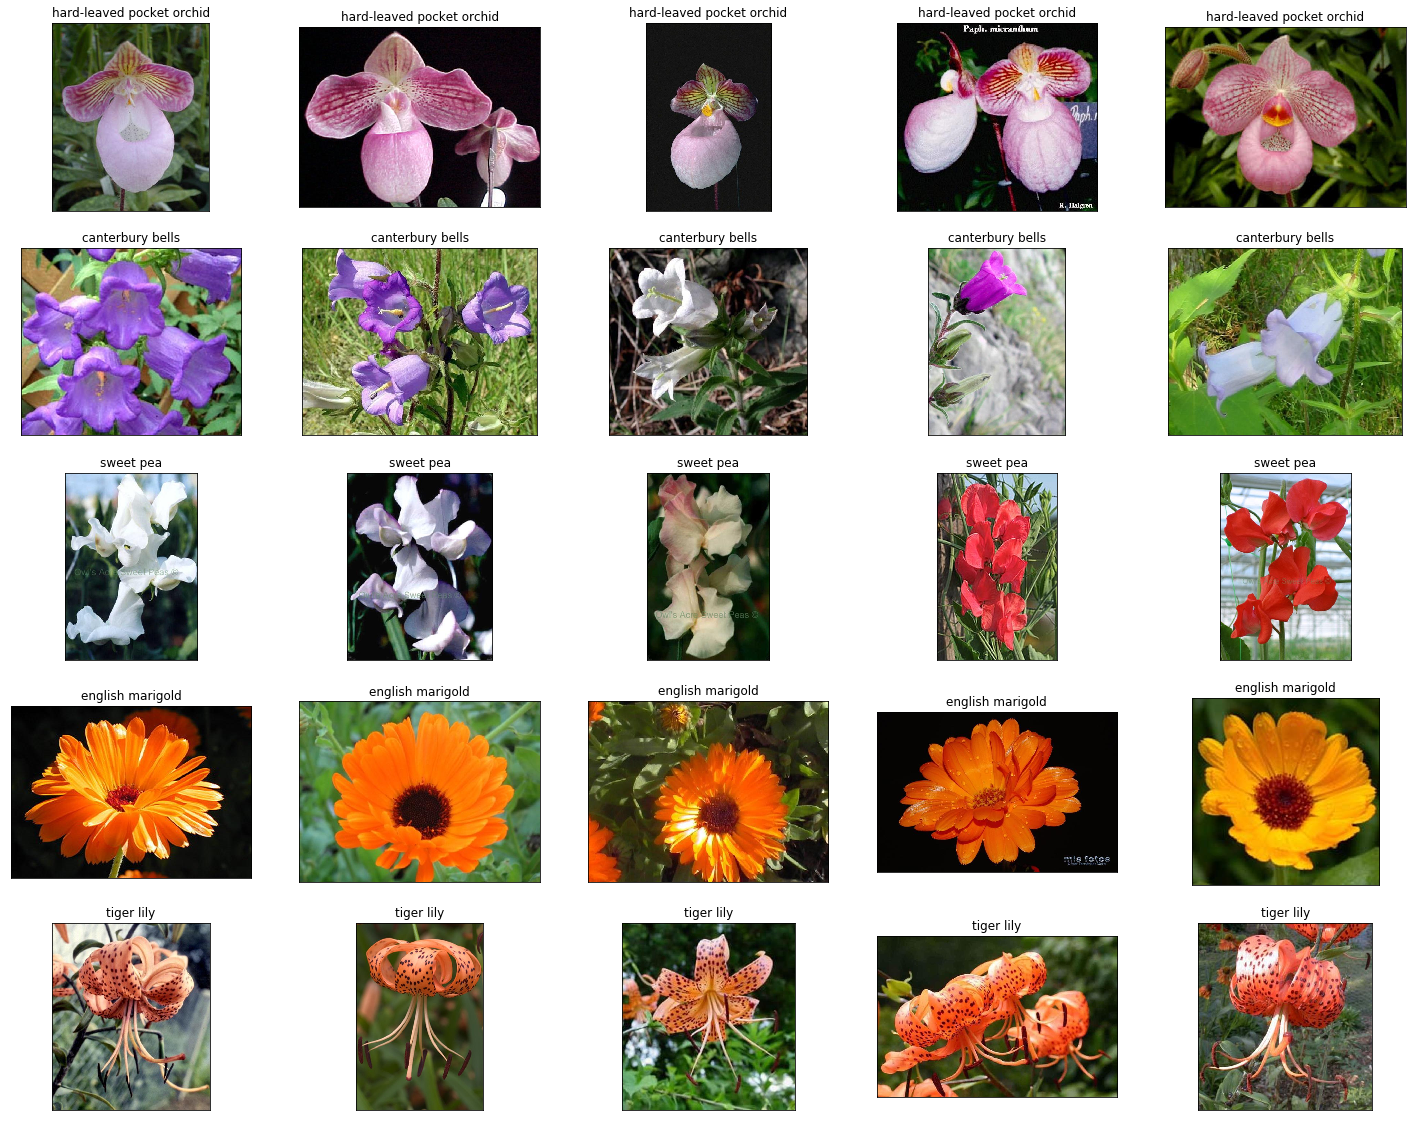

In [11]:
display_image(flower_images)

# Benchmark model
Using a very simple custom CNN to make sure our data was loaded correctly and working properly.

In [14]:
bench_model = Sequential()
bench_model.add(Conv2D(256, kernel_size=2, input_shape=(224, 224, 3), activation='relu'))
bench_model.add(GlobalAveragePooling2D())
bench_model.add(Dropout(0.5))
bench_model.add(Dense(128, activation='relu'))
bench_model.add(Dropout(0.2))
bench_model.add(Dense(train_generator.num_classes, activation='softmax'))

In [15]:
## Create our main model
predicted_model = Model(inputs=bench_model.input, outputs=bench_model.output)
predicted_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 223, 223, 256)     3328      
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 102)               13158     
Total para

In [16]:
## Compile our model
predicted_model.compile(
    loss='categorical_crossentropy', # Since we have multi-class categories in our dataset
    optimizer=optimizers.adam(1e-5),
    metrics=['accuracy']
)

## Getting callbacks
checkpoint = get_checkpoint(benchmark_model_dir)
callbacks = [checkpoint, early_stopping]

In [15]:
## Training model
training_history = predicted_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_step_size,
    validation_steps=valid_step_size,
    epochs=5,
    verbose=1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
92/92 [==============================] - 122s 1s/step - loss: 4.6243 - acc: 0.0121 - val_loss: 4.6236 - val_acc: 0.0243

Epoch 00001: val_acc improved from -inf to 0.02431, saving model to benchmark_model.h5
Epoch 2/5
92/92 [==============================] - 106s 1s/step - loss: 4.6236 - acc: 0.0148 - val_loss: 4.6235 - val_acc: 0.0110

Epoch 00002: val_acc did not improve from 0.02431
Epoch 3/5
92/92 [==============================] - 107s 1s/step - loss: 4.6227 - acc: 0.0151 - val_loss: 4.6211 - val_acc: 0.0239

Epoch 00003: val_acc did not improve from 0.02431
Epoch 4/5
92/92 [==============================] - 108s 1s/step - loss: 4.6217 - acc: 0.0158 - val_loss: 4.6198 - val_acc: 0.0257

Epoch 00004: val_acc improved from 0.02431 to 0.02569, saving model to benchmark_model.h5
Epoch 5/5
92/92 [==============================] - 108s 1s/step - loss: 4.6208 - acc: 0.0157 - val_loss: 4.6194 - val_acc: 0.0349

Epoch 00005: val_acc

As expected, a benchmark model built with simple architecture containing only a few Dense layers is definitely not enough to produce good result, since this model knows nothing about our current dataset. 

We will need a model with more knowledge on lower levels, to extract the foundation features out from the given images, using a pre-trained model such as VGG-19, which has already been trained on ImageNet through 1000 images. This way we can modify this pre-trained model using Transfer Learning technique to solve our unique problem with customized Dense layers.

## Model creation - VGG-19 Transfer Learning

Download VGG-19 with pre-trained weights from ImageNet. We then exclude its top layer since we want to predict our own 102 different categories of flower.

In [16]:
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size[0], input_size[1], channels)
)

80142336/80134624 [==============================] - 1s 0us/step


In [17]:
def inspect_model(model):
    for index, layer in enumerate(base_model.layers):
        print('Layer #{}: {} - Trainable: {}\nWeights: {}\n'.format(index, layer, layer.trainable, layer.trainable_weights))

In [18]:
inspect_model(base_model)

Layer #0: <keras.engine.input_layer.InputLayer object at 0x7fd74c0ae240> - Trainable: False
Weights: []

Layer #1: <keras.layers.convolutional.Conv2D object at 0x7fd74c0aeef0> - Trainable: True
Weights: [<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>, <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32_ref>]

Layer #2: <keras.layers.convolutional.Conv2D object at 0x7fd73c3b9828> - Trainable: True
Weights: [<tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32_ref>]

Layer #3: <keras.layers.pooling.MaxPooling2D object at 0x7fd73c2c07b8> - Trainable: True
Weights: []

Layer #4: <keras.layers.convolutional.Conv2D object at 0x7fd73c2c0278> - Trainable: True
Weights: [<tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32_ref>]

Layer #5: <keras.layers.convolutional.Conv2D object at 0x

In [19]:
############################################################################
# Since our data is similar to images in ImageNet database, and it
# can be considered as small (only few thousands of images in total),
# we can freeze the all the layers except the fully-connected (FC) layers
# since we can expect the higher-level featuers in the pre-trained model
# to be relevant to our data, so we only train them (the FC layers).
############################################################################

## Here we train only the top layers by freezing all the layers that are already pre-trained
for layer in base_model.layers:
    layer.trainable = False
    
# Now add some custom layers into our model
net = Flatten(name='flatten')(base_model.output)
net = Dense(4096, activation='relu')(net)
net = Dropout(0.5)(net)
net = Dense(2048, activation='relu')(net)
net = Dropout(0.5)(net)
net = Dense(train_generator.num_classes, 
            activation='softmax')(net) # 102 output classes

In [20]:
# Create our main model
predicted_model = Model(inputs=base_model.input, outputs=net)

predicted_model.summary()
inspect_model(base_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
# Compile our model
predicted_model.compile(
    loss='categorical_crossentropy', # Since we have multi-class categories in our dataset
    optimizer=optimizers.adam(1e-5),
    metrics=['accuracy']
)

checkpoint = get_checkpoint(best_model_dir)
callbacks = [checkpoint, early_stopping]

## Training model (Simple version - freezing all convolutional layers)

In [22]:
training_history = predicted_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_step_size,
    validation_steps=valid_step_size,
    epochs=10,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
92/92 [==============================] - 115s 1s/step - loss: 4.7807 - acc: 0.0340 - val_loss: 4.2403 - val_acc: 0.1339

Epoch 00001: val_acc improved from -inf to 0.13394, saving model to best_model.h5
Epoch 2/10
92/92 [==============================] - 108s 1s/step - loss: 4.3624 - acc: 0.0683 - val_loss: 4.1042 - val_acc: 0.1211

Epoch 00002: val_acc did not improve from 0.13394
Epoch 3/10
92/92 [==============================] - 107s 1s/step - loss: 4.0887 - acc: 0.1178 - val_loss: 3.7382 - val_acc: 0.2422

Epoch 00003: val_acc improved from 0.13394 to 0.24220, saving model to best_model.h5
Epoch 4/10
92/92 [==============================] - 108s 1s/step - loss: 3.8213 - acc: 0.1632 - val_loss: 3.3927 - val_acc: 0.3303

Epoch 00004: val_acc improved from 0.24220 to 0.33028, saving model to best_model.h5
Epoch 5/10
92/92 [==============================] - 108s 1s/step - loss: 3.5675 - acc: 0.2060 - val_loss: 3.1848 - val_acc: 0.3321

Epoch 00005: val_acc improved from 0.3

## Losses Visualization

In [23]:
def plot_model(trainning_history):
    train_accuracy = training_history.history['acc']
    val_accuracy = training_history.history['val_acc']
    
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    
    num_epochs = range(len(train_accuracy))
    plt.plot(num_epochs, train_accuracy, 'g', label='Training')
    plt.plot(num_epochs, val_accuracy, 'r', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(num_epochs, train_loss, 'b', label='Training')
    plt.plot(num_epochs, val_loss, 'r', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    plt.show()

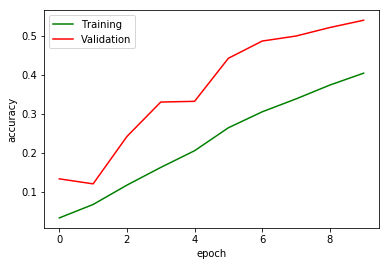

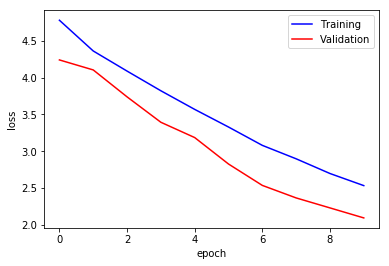

In [24]:
plot_model(training_history)

## Loading checkpoint with best weights for our model and fine-tune

In [25]:
predicted_model.load_weights(best_model_dir)

In [26]:
## Now unfreeze another last 8 layers from Convolutional base to let the model learn more
pretrained_model = predicted_model.layers
num_unfrozen_layers = -num_unfrozen_layers - 8

for layer in pretrained_model[:num_unfrozen_layers]:
    layer.trainable = False
for layer in pretrained_model[num_unfrozen_layers:]:
    layer.trainable = True
    
inspect_model(predicted_model.layers)
predicted_model.layers

Layer #0: <keras.engine.input_layer.InputLayer object at 0x7fd74c0ae240> - Trainable: False
Weights: []

Layer #1: <keras.layers.convolutional.Conv2D object at 0x7fd74c0aeef0> - Trainable: False
Weights: []

Layer #2: <keras.layers.convolutional.Conv2D object at 0x7fd73c3b9828> - Trainable: False
Weights: []

Layer #3: <keras.layers.pooling.MaxPooling2D object at 0x7fd73c2c07b8> - Trainable: False
Weights: []

Layer #4: <keras.layers.convolutional.Conv2D object at 0x7fd73c2c0278> - Trainable: False
Weights: []

Layer #5: <keras.layers.convolutional.Conv2D object at 0x7fd73c21beb8> - Trainable: False
Weights: []

Layer #6: <keras.layers.pooling.MaxPooling2D object at 0x7fd73c247390> - Trainable: False
Weights: []

Layer #7: <keras.layers.convolutional.Conv2D object at 0x7fd73c247b00> - Trainable: False
Weights: []

Layer #8: <keras.layers.convolutional.Conv2D object at 0x7fd73c1f42b0> - Trainable: False
Weights: []

Layer #9: <keras.layers.convolutional.Conv2D object at 0x7fd73c1ab898> 

In [27]:
predicted_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.adam(1e-5),
                        metrics=['accuracy'])

checkpoint = get_checkpoint(final_model_dir)
callbacks = [checkpoint, early_stopping]

In [28]:
training_history = predicted_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_step_size,
    validation_steps=valid_step_size,
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20
92/92 [==============================] - 121s 1s/step - loss: 1.9103 - acc: 0.5174 - val_loss: 1.1833 - val_acc: 0.7119

Epoch 00001: val_acc improved from -inf to 0.71193, saving model to final_model.h5
Epoch 2/20
92/92 [==============================] - 118s 1s/step - loss: 1.4737 - acc: 0.6166 - val_loss: 1.0045 - val_acc: 0.7587

Epoch 00002: val_acc improved from 0.71193 to 0.75868, saving model to final_model.h5
Epoch 3/20
92/92 [==============================] - 112s 1s/step - loss: 1.2730 - acc: 0.6545 - val_loss: 0.8030 - val_acc: 0.7872

Epoch 00003: val_acc improved from 0.75868 to 0.78716, saving model to final_model.h5
Epoch 4/20
92/92 [==============================] - 111s 1s/step - loss: 1.0982 - acc: 0.7053 - val_loss: 0.7507 - val_acc: 0.7908

Epoch 00004: val_acc improved from 0.78716 to 0.79083, saving model to final_model.h5
Epoch 5/20
92/92 [==============================] - 111s 1s/step - loss: 0.9719 - acc: 0.7305 - val_loss: 0.6998 - val_acc: 0.8128


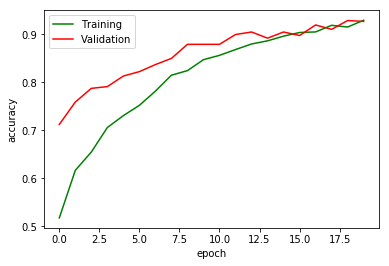

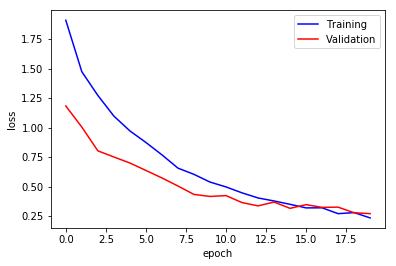

In [29]:
plot_model(training_history)

In [30]:
model_saved_json = predicted_model.to_json()

with open('../models/' + 'model.json', 'w') as json_file:
    json_file.write(model_saved_json)

## Evaluate Model

In [31]:
predicted_model.load_weights(final_model_dir)

In [32]:
evaluation = predicted_model.evaluate_generator(valid_generator, 
                                                steps=valid_generator.batch_size)

In [33]:
print(evaluation)

[0.29231724081289434, 0.9150895146152858]


In [34]:
test_generator.reset()
prediction = predicted_model.predict_generator(test_generator,
                                               steps=len(test_generator.classes), verbose=1)

predicted_classes = np.argmax(prediction, axis=1)

818/818 [==============================] - 19s 23ms/step


In [35]:
## Only get the file name from respective folders
file_indices = test_generator.filenames
file_name_indices = [file_name.split('/')[1] for file_name in file_indices]

## Getting predictions with labels
labels = dict((value, key) for key, value in train_generator.class_indices.items())
predictions = [labels[key] for key in predicted_classes]
predicted_labels = [flower_names[str(label)] for label in predictions]

## Actual identities of test images
ground_truths = [file_name.split('/')[0] for file_name in file_indices]
ground_truth_labels = [flower_names[str(label)] for label in ground_truths]

results = pd.DataFrame({
    "Filename": file_name_indices,
    "Prediction": predictions,
    "Predicted label": predicted_labels,
    "Ground truth": ground_truths,
    "Grouth truth label": ground_truth_labels
})
results.to_csv("results.csv", index=False)
# results.to_csv("../files/results.csv", index=False)
results

Filename        ...         Grouth truth label
0    image_06739.jpg        ...              pink primrose
1    image_06749.jpg        ...              pink primrose
2    image_06755.jpg        ...              pink primrose
3    image_06756.jpg        ...              pink primrose
4    image_06758.jpg        ...              pink primrose
5    image_06763.jpg        ...              pink primrose
6    image_06765.jpg        ...              pink primrose
7    image_06769.jpg        ...              pink primrose
8    image_07094.jpg        ...              globe thistle
9    image_07101.jpg        ...              globe thistle
10   image_07102.jpg        ...              globe thistle
11   image_07107.jpg        ...              globe thistle
12   image_07895.jpg        ...             blanket flower
13   image_07904.jpg        ...             blanket flower
14   image_07905.jpg        ...             blanket flower
15   image_07917.jpg        ...             blanket flower
16   image_07929.jpg        ...             blanket flower
17   image_07931.jpg        ...             blanket flower
18   image_07951.jpg        ...            trumpet creeper
19   image_07962.jpg        ...            trumpet creeper
20   image_07963.jpg        ...            trumpet creeper
21   image_07970.jpg        ...            trumpet creeper
22   image_07985.jpg        ...            trumpet creeper
23   image_08002.jpg        ...            blackberry lily
24   image_08006.jpg        ...            blackberry lily
25   image_08014.jpg        ...            blackberry lily
26   image_08038.jpg        ...            blackberry lily
27   image_08040.jpg        ...            blackberry lily
28   image_08041.jpg        ...            blackberry lily
29   image_03100.jpg        ...                 snapdragon
..               ...        ...                        ...
788  image_07653.jpg        ...                   camellia
789  image_07656.jpg        ...                   camellia
790  image_07658.jpg        ...                   camellia
791  image_07662.jpg        ...                   camellia
792  image_07669.jpg        ...                   camellia
793  image_07670.jpg        ...                   camellia
794  image_07677.jpg        ...                   camellia
795  image_07697.jpg        ...                     mallow
796  image_07699.jpg        ...                     mallow
797  image_07718.jpg        ...                     mallow
798  image_07723.jpg        ...                     mallow
799  image_07727.jpg        ...                     mallow
800  image_07739.jpg        ...                     mallow
801  image_07745.jpg        ...                     mallow
802  image_07757.jpg        ...            mexican petunia
803  image_07764.jpg        ...            mexican petunia
804  image_07766.jpg        ...            mexican petunia
805  image_07769.jpg        ...            mexican petunia
806  image_07778.jpg        ...            mexican petunia
807  image_07792.jpg        ...            mexican petunia
808  image_07796.jpg        ...            mexican petunia
809  image_07810.jpg        ...            mexican petunia
810  image_07820.jpg        ...            mexican petunia
811  image_07827.jpg        ...            mexican petunia
812  image_07860.jpg        ...                   bromelia
813  image_07862.jpg        ...                   bromelia
814  image_07869.jpg        ...                   bromelia
815  image_07873.jpg        ...                   bromelia
816  image_07875.jpg        ...                   bromelia
817  image_08063.jpg        ...                   bromelia

[818 rows x 5 columns]

## Visualization

Drawing heatmap for confusion matrix on how well our model performs.

In [36]:
flowers = Counter(test_labels)
flowers_names = [str(key) for key in flowers.keys()]

print(flowers)

while flowers:
    print(flowers.popitem())

Counter({77: 251, 73: 194, 89: 183, 81: 166, 88: 152, 46: 54})
(46, 54)
(81, 166)
(89, 183)
(88, 152)
(73, 194)
(77, 251)


## Metrics

In [37]:
## Flower categories not being predicted, let's just ignore this type prediction result when
## measuring model performace.
flower_not_predicted = set(ground_truths) - set(predictions)
for flower_not in flower_not_predicted:
    print("Flowers not being predicted: {}\n".format((flower_not, flower_names[flower_not])))

## Calculate all possible performance metrics to see how well our model is doing
accuracy_result = accuracy_score(ground_truths, 
                                 predictions) * 100
precision_score_result = precision_score(ground_truths, predictions, average="weighted", 
                                         labels=np.unique(predictions)) * 100
recall_score_result = recall_score(ground_truths, predictions, average="weighted", 
                                   labels=np.unique(predictions)) * 100
f1_score_result = f1_score(ground_truths, predictions, average="weighted",
                           labels=np.unique(predictions)) * 100

print("Accuracy: {:.2f}%\nPrecision score: {:.2f}%\nRecall score: {:.2f}%\nF1-score: {:.2f}%"
      .format(accuracy_result, precision_score_result, recall_score_result, f1_score_result))

Flowers not being predicted: ('14', 'spear thistle')

Flowers not being predicted: ('7', 'moon orchid')

Accuracy: 90.95%
Precision score: 91.88%
Recall score: 91.18%
F1-score: 90.90%


Text(339.0, 0.5, 'Predicted label')

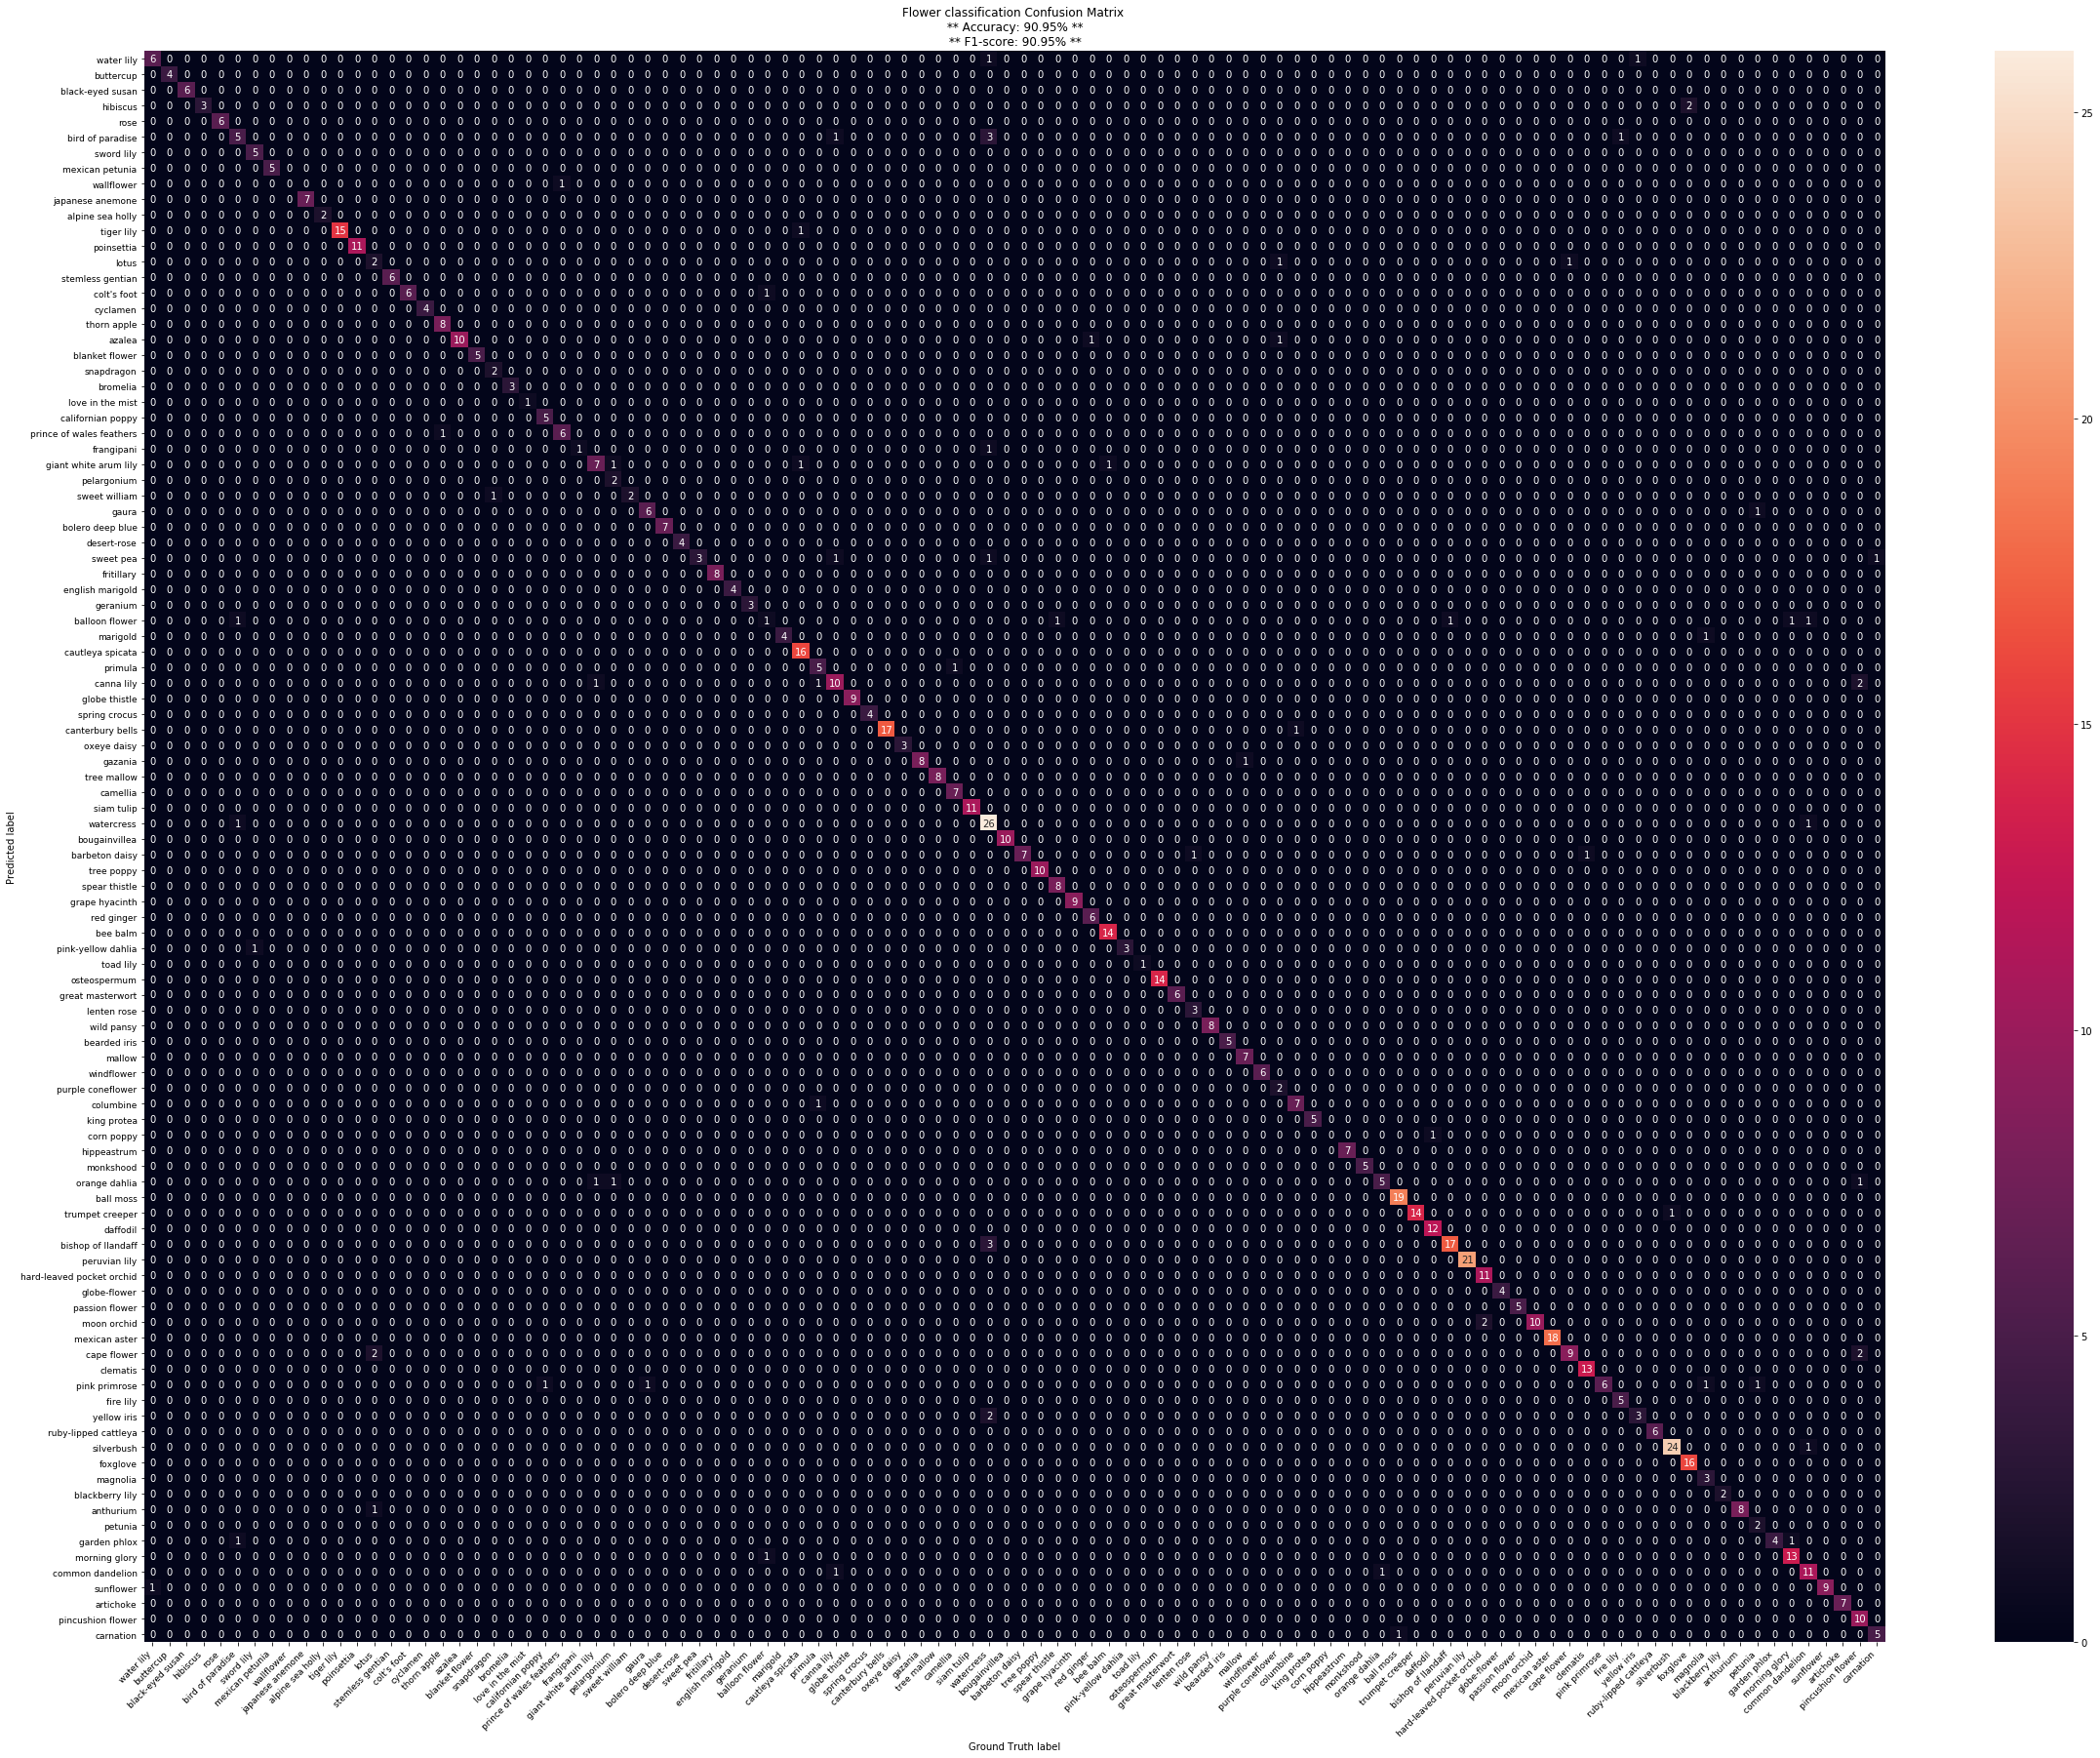

In [38]:
fig = plt.figure(figsize=(40, 30))

try:
    matrix = confusion_matrix(ground_truths, predictions)
    axis_label = set(ground_truth_labels)
    matrix_dataFrame = pd.DataFrame(matrix,
                      index=axis_label,
                      columns=axis_label)
    heatmap = sns.heatmap(matrix_dataFrame, annot=True, fmt="d")
    
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
    
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                             rotation=0, ha='right', fontsize=9.0)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', fontsize=9.0)

plt.title('Flower classification Confusion Matrix \n** Accuracy: {0:.2f}% **\n** F1-score: {0:.2f}% **'
          .format(accuracy_result, f1_score_result))
plt.xlabel('Ground Truth label')
plt.ylabel('Predicted label')

In [39]:
## Cleanup session for backend
k.clear_session()